In [1]:
import os
import sys
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch import LightningDataModule
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import Pk_library as PKL

sys.path.append(os.path.expanduser("~"))
from camel_dataloader import *
from utils import draw_figure, compute_pk, plot_residual
from UNet_apply import applyCNN, applyCNN_TF

[rank: 0] Seed set to 7


cuda


# Dataloader $M_{cdm}+\lambda M_{cdm}^{\alpha}$

In [42]:
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'

class ToyDataModule(LightningDataModule): 

    def __init__(
            self, 
            train_transforms=None, 
            test_transforms=None, 
            batch_size=1,
            num_workers=1,
            dataset='Astrid',
            thickness=25
        ):
        super().__init__()
        self.train_transforms = train_transforms
        self.test_transforms = test_transforms
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset = dataset
        self.thickness = thickness

    def setup(self, stage=None):
        mass_mtot = None
        mass_cdm = None
        params = None
        if self.thickness == 25:
            # Load CDM mass and parameters
            mass_cdm = np.load(train_dir+
                    f'Grids_Mtot_Nbody_{self.dataset}_LH_256_z=0.0.npy'
                )
            params = np.loadtxt(train_dir+
                    f'params_LH_{self.dataset}.txt'
                )
            
            #3D-->2D 25Mpc thick [3000,1,256,256]
            mass_cdm = np.concatenate((mass_cdm.mean(axis = 1),
                                     mass_cdm.mean(axis = 2),
                                     mass_cdm.mean(axis = 3)), axis=0)
            
            # Generate random constant between -0.5 and 0.5 for each sample
            np.random.seed(42)  # for reproducibility
            random_constants = np.random.uniform(-0.5, 0.5, size=len(mass_cdm))
            
            # Calculate m_tot as m_cdm + random_constant * m_cdm^2
            mass_mtot = mass_cdm + random_constants[:, np.newaxis, np.newaxis] * (mass_cdm ** 2)
            
            # Convert to tensors and add channel dimension
            mass_mtot = Tensor(mass_mtot).unsqueeze(1)
            mass_cdm = Tensor(mass_cdm).unsqueeze(1)
            
            # Prepare parameters array
            maps_params = np.empty((len(mass_mtot), 6))
            for i in range(len(mass_mtot)):
                maps_params[i] = np.full(6, random_constants[i//3])
                
        maps_params = Tensor(np.asarray(maps_params))
        data = AstroDataset(mass_cdm, maps_params, mass_mtot, transform=self.train_transforms)
        
        # Split data into train, validation, and test sets
        train_set_size = int(len(data) * 0.7)
        valid_set_size = int(len(data) * 0.2)
        test_set_size = len(data)-valid_set_size-train_set_size
        generator = torch.Generator().manual_seed(342)
        self.train_data, self.valid_data, self.test_data = random_split(
                data, [train_set_size, valid_set_size, test_set_size], generator=generator
            )


    def train_dataloader(self):
        return DataLoader(
            self.train_data, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers, 
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_data, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=True
        )  #Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.

    def test_dataloader(self):
        return DataLoader(
            self.test_data, 
            batch_size= 50, 
            num_workers=self.num_workers
        ) #load all test data at once for plotting


def get_toy_data(dataset, thickness, num_workers=1, batch_size=10, stage=None, resize=None): #map thickness <= 25 Mpc/h

    train_transforms = [
                Normalize(dataset),
                Translate(),
                Flip(2),
                RandomRotation([90, 180, 270]) #rotate +-90 degrees
            ]

    test_transforms = [Normalize(dataset)] 

    if resize is not None:
        train_transforms += [Resize(resize)]
        test_transforms += [Resize(resize)]

    train_transforms = transforms.Compose(train_transforms)
    test_transforms = transforms.Compose(test_transforms)

    dm = ToyDataModule(
        train_transforms=train_transforms,
        test_transforms=test_transforms,
        num_workers=num_workers,
        batch_size=batch_size,
        dataset=dataset,
        thickness=thickness
    )
    dm.setup(stage=stage)
    return dm

In [43]:
dm_toy = get_toy_data(
        dataset,
        thickness=25,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time t

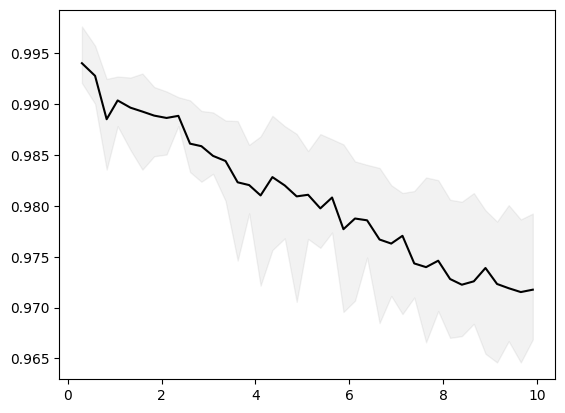

In [28]:
simulations = np.arange(0, 300, 20)
rcc_nbody =[]
for i in simulations:
    conditioning, params, target = dm_toy.test_data[i]
   

    Pk2D_hydro = PKL.Pk_plane((conditioning+target).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane((conditioning).detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
    Pkcc = PKL.XPk_plane((conditioning+target).detach().numpy().reshape([256,256]),(conditioning).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc_true   = Pkcc.k
    Pk0_X_true = Pkcc.r

    rcc_nbody.append(Pk0_X_true[kcc_true<=10])
    
plt.figure()
median_spectrum = np.mean(rcc_nbody, axis=0)
min_spectrum = np.percentile(rcc_nbody, 16, axis=0)
max_spectrum = np.percentile(rcc_nbody, 84, axis=0)
plt.plot(kcc_true[kcc_true <= 10], median_spectrum, color='k',label=r'$\lambda \times {Nbody}^2$')
plt.fill_between(kcc_true[kcc_true <= 10], min_spectrum, max_spectrum, color='k', alpha=0.05)

# Train with best CNN-Film: moving high-k without high pass

In [29]:
class trainCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-2,
        n_sampling_steps: int = 250, 
        fourier_upweight_range=(3, 10), 
        fourier_weight=1e-5,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        self.fourier_upweight_range = fourier_upweight_range
        self.fourier_weight = fourier_weight
        
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, cdm_map, params) -> Tensor:
        cdm_map = cdm_map
        params = params
        return self.model(cdm_map,params)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        true_map = true_map.to(device)
        mtot_pred = self(cdm_map,params).to(device)
        fourier_loss = self.fourier_loss(mtot_pred, true_map)
        # Log the individual loss components
        self.log("fourier_loss", fourier_loss, on_epoch=True, prog_bar=True)
        loss = l1_loss(mtot_pred, true_map)
        self.log("l1_loss", loss, on_epoch=True, prog_bar=True)
        #if self.current_epoch >= 2:
            #loss += fourier_loss
        return fourier_loss

    def get_current_max_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[1]
            
        progress = self.current_epoch / self.trainer.max_epochs
        max_freq = self.fourier_upweight_range[1]
    
        if progress < 0.33:
            return max_freq / 3
        elif progress < 0.66:
            return (max_freq * 2) / 3
        else:
            return max_freq

    def get_current_min_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[0]
            
        progress = self.current_epoch / self.trainer.max_epochs
        min_freq = self.fourier_upweight_range[0]
    
        if progress < 0.33:
            return 0.5
        elif progress < 0.66:
            return (min_freq * 2) / 3
        else:
            return min_freq
       
    
    def fourier_loss(self, output, target):

        output_fft = torch.fft.fft2(output)
        target_fft = torch.fft.fft2(target)
    
        _, _, H, W = output.shape
        L = 25. #Mpc/c

        kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L)).to(output.device)
        ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L)).to(output.device)
        kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
        k = torch.sqrt(kx**2 + ky**2) 
        
        high = self.get_current_max_freq() #self.get_current_max_freq[1]
        low = self.get_current_min_freq() #self.fourier_upweight_range[0]
        order = 2 
        low_pass = 1 / (1 + (k / high)**(2 * order))
        high_pass = 1 / (1 + (low / k)**(2 * order))
        weight_mask = self.fourier_weight*low_pass 
        #weight_mask = self.fourier_weight*low_pass*high_pass #change to Butterworth filter
        
        #weight_mask = torch.zeros_like(k)
        #weight_mask[(k >= low) & (k <= high)] = self.fourier_weight # Double weight in the range
    
        # Expand the mask for all batches and channels
        weight_mask = weight_mask[None, None, :, :].to(output.device)
        loss = torch.mean(weight_mask * (output_fft - target_fft).real ** 2) + torch.mean(weight_mask * (output_fft - target_fft).imag ** 2) #r_cc is phase not mag

        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        loss = self.evaluate(batch, "train")
        self.log("train_loss", loss, on_epoch=True)
        log_loss = torch.log(loss)
        return log_loss


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params,x = batch 
        loss = self.evaluate(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10, # ~ num_steps // 3
            eta_min=3e-5,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        cdm_map,params,true_map = batch
        return self(cdm_map,params)


sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNetFiLM
device = torch.device("cuda") 
cnn = trainCNN(
        model =UNetFiLM(1,1,use_fourier_features=False), #.to(device) #SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=1e-3,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    ).to(device)

    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, # 50 6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="toy_model",
            experiment_name='UNet_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody_power_1.3',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=20, #10 1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model=cnn, datamodule=dm_toy) 

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | UNetFiLM | 44.2 M | train
-------------------------------------------
44.2 M    Trainable params
0         Non-trainable params
44.2 M    Total params
176.874   Total estimated model params size (MB)
104 

no high passing DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds



/global/homes/l/lindajin/utils.py:212: RuntimeWarning: invalid value encountered in log
  im = ax.flat[2].imshow(np.log(sample0+1), cmap='copper', vmin=-2, vmax=5)



Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time t

Epoch 0, global step 175: 'val_loss' reached 0.30288 (best 0.30288), saving model to '/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.0938, l1_loss_step=0.335, fourier_loss=0.303, l1_loss=0.412, val_loss=0.303, fourier_loss_epoch=0.183, l1_loss_epoch=0.321]          
no high pass%|          | 1/175 [00:00<01:05,  2.65it/s, v_num=bf58, fourier_loss_step=0.100, l1_loss_step=0.302, fourier_loss=0.303, l1_loss=0.412, val_loss=0.303, fourier_loss_epoch=0.183, l1_loss_epoch=0.321] 
no high pass%|          | 2/175 [00:00<00:43,  3.95it/s, v_num=bf58, fourier_loss_step=0.107, l1_loss_step=0.322, fourier_loss=0.303, l1_loss=0.412, val_loss=0.303, fourier_loss_epoch=0.183, l1_loss_epoch=0.321]
no high pass%|▏         | 3/175 [00:00<00:36,  4.70it/s, v_num=bf58, fourier_loss_step=0.164, l1_loss_step=0.313, fourier_loss=0.303, l1_loss=0.412, val_loss=0.303, fourier_loss_epoch=0.183, l1_loss_epoch=0.321]
no high pass%|▏         | 4/175 [00:00<00:32,  5.21it/s, v_num=bf58, fourier_loss_step=0.0855, l1_loss_step=0.296, fourier_loss=0.303, l1_loss=0.412

Epoch 1, global step 350: 'val_loss' reached 0.15105 (best 0.15105), saving model to '/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/best_model-epoch=1-step=350.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.0281, l1_loss_step=0.308, fourier_loss=0.151, l1_loss=0.550, val_loss=0.151, fourier_loss_epoch=0.0781, l1_loss_epoch=0.315]          
no high pass%|          | 1/175 [00:00<01:21,  2.13it/s, v_num=bf58, fourier_loss_step=0.0854, l1_loss_step=0.277, fourier_loss=0.151, l1_loss=0.550, val_loss=0.151, fourier_loss_epoch=0.0781, l1_loss_epoch=0.315]
no high pass%|          | 2/175 [00:00<00:51,  3.33it/s, v_num=bf58, fourier_loss_step=0.0113, l1_loss_step=0.300, fourier_loss=0.151, l1_loss=0.550, val_loss=0.151, fourier_loss_epoch=0.0781, l1_loss_epoch=0.315]
no high pass%|▏         | 3/175 [00:00<00:41,  4.12it/s, v_num=bf58, fourier_loss_step=0.0594, l1_loss_step=0.287, fourier_loss=0.151, l1_loss=0.550, val_loss=0.151, fourier_loss_epoch=0.0781, l1_loss_epoch=0.315]
no high pass%|▏         | 4/175 [00:00<00:36,  4.67it/s, v_num=bf58, fourier_loss_step=0.125, l1_loss_step=0.292, fourier_loss=0.151, l1_loss=

Epoch 2, global step 525: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.141, l1_loss_step=0.252, fourier_loss=0.268, l1_loss=0.288, val_loss=0.268, fourier_loss_epoch=0.0787, l1_loss_epoch=0.285]          
no high pass%|          | 1/175 [00:00<01:05,  2.66it/s, v_num=bf58, fourier_loss_step=0.216, l1_loss_step=0.252, fourier_loss=0.268, l1_loss=0.288, val_loss=0.268, fourier_loss_epoch=0.0787, l1_loss_epoch=0.285]
no high pass%|          | 2/175 [00:00<00:43,  3.96it/s, v_num=bf58, fourier_loss_step=0.0873, l1_loss_step=0.249, fourier_loss=0.268, l1_loss=0.288, val_loss=0.268, fourier_loss_epoch=0.0787, l1_loss_epoch=0.285]
no high pass%|▏         | 3/175 [00:00<00:36,  4.73it/s, v_num=bf58, fourier_loss_step=0.0138, l1_loss_step=0.248, fourier_loss=0.268, l1_loss=0.288, val_loss=0.268, fourier_loss_epoch=0.0787, l1_loss_epoch=0.285]
no high pass%|▏         | 4/175 [00:00<00:32,  5.24it/s, v_num=bf58, fourier_loss_step=0.0207, l1_loss_step=0.250, fourier_loss=0.268, l1_loss=0

Epoch 3, global step 700: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.222, l1_loss_step=0.241, fourier_loss=0.190, l1_loss=0.262, val_loss=0.190, fourier_loss_epoch=0.0708, l1_loss_epoch=0.261]          
no high pass%|          | 1/175 [00:00<01:06,  2.61it/s, v_num=bf58, fourier_loss_step=0.0165, l1_loss_step=0.232, fourier_loss=0.190, l1_loss=0.262, val_loss=0.190, fourier_loss_epoch=0.0708, l1_loss_epoch=0.261]
no high pass%|          | 2/175 [00:00<00:44,  3.89it/s, v_num=bf58, fourier_loss_step=0.0759, l1_loss_step=0.242, fourier_loss=0.190, l1_loss=0.262, val_loss=0.190, fourier_loss_epoch=0.0708, l1_loss_epoch=0.261]
no high pass%|▏         | 3/175 [00:00<00:36,  4.66it/s, v_num=bf58, fourier_loss_step=0.0481, l1_loss_step=0.241, fourier_loss=0.190, l1_loss=0.262, val_loss=0.190, fourier_loss_epoch=0.0708, l1_loss_epoch=0.261]
no high pass%|▏         | 4/175 [00:00<00:33,  5.17it/s, v_num=bf58, fourier_loss_step=0.0443, l1_loss_step=0.247, fourier_loss=0.190, l1_loss=

Epoch 4, global step 875: 'val_loss' reached 0.02320 (best 0.02320), saving model to '/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/best_model-epoch=4-step=875.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.0466, l1_loss_step=0.256, fourier_loss=0.0232, l1_loss=0.233, val_loss=0.0232, fourier_loss_epoch=0.0585, l1_loss_epoch=0.249]          
no high pass%|          | 1/175 [00:00<01:10,  2.46it/s, v_num=bf58, fourier_loss_step=0.0193, l1_loss_step=0.246, fourier_loss=0.0232, l1_loss=0.233, val_loss=0.0232, fourier_loss_epoch=0.0585, l1_loss_epoch=0.249]
no high pass%|          | 2/175 [00:00<00:46,  3.74it/s, v_num=bf58, fourier_loss_step=0.0133, l1_loss_step=0.247, fourier_loss=0.0232, l1_loss=0.233, val_loss=0.0232, fourier_loss_epoch=0.0585, l1_loss_epoch=0.249]
no high pass%|▏         | 3/175 [00:00<00:38,  4.50it/s, v_num=bf58, fourier_loss_step=0.0207, l1_loss_step=0.247, fourier_loss=0.0232, l1_loss=0.233, val_loss=0.0232, fourier_loss_epoch=0.0585, l1_loss_epoch=0.249]
no high pass%|▏         | 4/175 [00:00<00:34,  5.03it/s, v_num=bf58, fourier_loss_step=0.0475, l1_loss_step=0.257, fourier_loss=0.0232

Epoch 5, global step 1050: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.0324, l1_loss_step=0.224, fourier_loss=0.0313, l1_loss=0.212, val_loss=0.0313, fourier_loss_epoch=0.0481, l1_loss_epoch=0.241]          
no high pass%|          | 1/175 [00:00<01:12,  2.41it/s, v_num=bf58, fourier_loss_step=0.0231, l1_loss_step=0.220, fourier_loss=0.0313, l1_loss=0.212, val_loss=0.0313, fourier_loss_epoch=0.0481, l1_loss_epoch=0.241]
no high pass%|          | 2/175 [00:00<00:47,  3.64it/s, v_num=bf58, fourier_loss_step=0.0575, l1_loss_step=0.243, fourier_loss=0.0313, l1_loss=0.212, val_loss=0.0313, fourier_loss_epoch=0.0481, l1_loss_epoch=0.241]
no high pass%|▏         | 3/175 [00:00<00:38,  4.41it/s, v_num=bf58, fourier_loss_step=0.0262, l1_loss_step=0.232, fourier_loss=0.0313, l1_loss=0.212, val_loss=0.0313, fourier_loss_epoch=0.0481, l1_loss_epoch=0.241]
no high pass%|▏         | 4/175 [00:00<00:34,  4.94it/s, v_num=bf58, fourier_loss_step=0.0491, l1_loss_step=0.229, fourier_loss=0.0313

Epoch 6, global step 1225: 'val_loss' reached 0.01701 (best 0.01701), saving model to '/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/best_model-epoch=6-step=1225.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.0511, l1_loss_step=0.236, fourier_loss=0.017, l1_loss=0.335, val_loss=0.017, fourier_loss_epoch=0.0394, l1_loss_epoch=0.219]          
no high pass%|          | 1/175 [00:00<01:10,  2.48it/s, v_num=bf58, fourier_loss_step=0.0559, l1_loss_step=0.224, fourier_loss=0.017, l1_loss=0.335, val_loss=0.017, fourier_loss_epoch=0.0394, l1_loss_epoch=0.219]
no high pass%|          | 2/175 [00:00<00:46,  3.74it/s, v_num=bf58, fourier_loss_step=0.0485, l1_loss_step=0.239, fourier_loss=0.017, l1_loss=0.335, val_loss=0.017, fourier_loss_epoch=0.0394, l1_loss_epoch=0.219]
no high pass%|▏         | 3/175 [00:00<00:38,  4.51it/s, v_num=bf58, fourier_loss_step=0.0493, l1_loss_step=0.226, fourier_loss=0.017, l1_loss=0.335, val_loss=0.017, fourier_loss_epoch=0.0394, l1_loss_epoch=0.219]
no high pass%|▏         | 4/175 [00:00<00:34,  5.02it/s, v_num=bf58, fourier_loss_step=0.0446, l1_loss_step=0.226, fourier_loss=0.017, l1_loss

Epoch 7, global step 1400: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.183, l1_loss_step=0.179, fourier_loss=0.0652, l1_loss=0.171, val_loss=0.0652, fourier_loss_epoch=0.0844, l1_loss_epoch=0.201]          
no high pass%|          | 1/175 [00:00<01:09,  2.49it/s, v_num=bf58, fourier_loss_step=0.0611, l1_loss_step=0.169, fourier_loss=0.0652, l1_loss=0.171, val_loss=0.0652, fourier_loss_epoch=0.0844, l1_loss_epoch=0.201]
no high pass%|          | 2/175 [00:00<00:46,  3.73it/s, v_num=bf58, fourier_loss_step=0.205, l1_loss_step=0.177, fourier_loss=0.0652, l1_loss=0.171, val_loss=0.0652, fourier_loss_epoch=0.0844, l1_loss_epoch=0.201] 
no high pass%|▏         | 3/175 [00:00<00:38,  4.51it/s, v_num=bf58, fourier_loss_step=0.0281, l1_loss_step=0.165, fourier_loss=0.0652, l1_loss=0.171, val_loss=0.0652, fourier_loss_epoch=0.0844, l1_loss_epoch=0.201]
no high pass%|▏         | 4/175 [00:00<00:33,  5.04it/s, v_num=bf58, fourier_loss_step=0.0512, l1_loss_step=0.166, fourier_loss=0.0652,

Epoch 8, global step 1575: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=bf58, fourier_loss_step=0.233, l1_loss_step=0.166, fourier_loss=0.0269, l1_loss=0.162, val_loss=0.0269, fourier_loss_epoch=0.0744, l1_loss_epoch=0.171]          
no high pass%|          | 1/175 [00:00<01:51,  1.56it/s, v_num=bf58, fourier_loss_step=0.374, l1_loss_step=0.175, fourier_loss=0.0269, l1_loss=0.162, val_loss=0.0269, fourier_loss_epoch=0.0744, l1_loss_epoch=0.171]
no high pass%|          | 2/175 [00:00<01:06,  2.59it/s, v_num=bf58, fourier_loss_step=0.0519, l1_loss_step=0.166, fourier_loss=0.0269, l1_loss=0.162, val_loss=0.0269, fourier_loss_epoch=0.0744, l1_loss_epoch=0.171]
no high pass%|▏         | 3/175 [00:00<00:51,  3.33it/s, v_num=bf58, fourier_loss_step=0.0372, l1_loss_step=0.168, fourier_loss=0.0269, l1_loss=0.162, val_loss=0.0269, fourier_loss_epoch=0.0744, l1_loss_epoch=0.171]
no high pass%|▏         | 4/175 [00:01<00:44,  3.87it/s, v_num=bf58, fourier_loss_step=0.024, l1_loss_step=0.160, fourier_loss=0.0269, l

Epoch 9, global step 1750: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 175/175 [00:27<00:00,  6.39it/s, v_num=bf58, fourier_loss_step=0.0251, l1_loss_step=0.179, fourier_loss=0.0242, l1_loss=0.162, val_loss=0.0242, fourier_loss_epoch=0.0702, l1_loss_epoch=0.163]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS 

Epoch 10, global step 1925: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 175/175 [00:27<00:00,  6.42it/s, v_num=bf58, fourier_loss_step=0.210, l1_loss_step=0.173, fourier_loss=0.729, l1_loss=0.569, val_loss=0.729, fourier_loss_epoch=0.101, l1_loss_epoch=0.221]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.

Epoch 11, global step 2100: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 175/175 [00:27<00:00,  6.46it/s, v_num=bf58, fourier_loss_step=0.144, l1_loss_step=0.144, fourier_loss=0.113, l1_loss=0.204, val_loss=0.113, fourier_loss_epoch=0.153, l1_loss_epoch=0.197]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.

Epoch 12, global step 2275: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 175/175 [00:27<00:00,  6.40it/s, v_num=bf58, fourier_loss_step=0.0287, l1_loss_step=0.134, fourier_loss=0.188, l1_loss=0.233, val_loss=0.188, fourier_loss_epoch=0.115, l1_loss_epoch=0.156]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0

Epoch 13, global step 2450: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 175/175 [00:27<00:00,  6.40it/s, v_num=bf58, fourier_loss_step=0.196, l1_loss_step=0.136, fourier_loss=0.246, l1_loss=0.218, val_loss=0.246, fourier_loss_epoch=0.116, l1_loss_epoch=0.141] 
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0

Epoch 14, global step 2625: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 175/175 [00:27<00:00,  6.43it/s, v_num=bf58, fourier_loss_step=0.0999, l1_loss_step=0.108, fourier_loss=0.0657, l1_loss=0.122, val_loss=0.0657, fourier_loss_epoch=0.152, l1_loss_epoch=0.134]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS =

Epoch 15, global step 2800: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 175/175 [00:27<00:00,  6.42it/s, v_num=bf58, fourier_loss_step=0.338, l1_loss_step=0.129, fourier_loss=0.484, l1_loss=0.383, val_loss=0.484, fourier_loss_epoch=0.133, l1_loss_epoch=0.112] 
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0

Epoch 16, global step 2975: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 175/175 [00:27<00:00,  6.37it/s, v_num=bf58, fourier_loss_step=0.0214, l1_loss_step=0.0895, fourier_loss=0.0531, l1_loss=0.104, val_loss=0.0531, fourier_loss_epoch=0.118, l1_loss_epoch=0.110]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS 

Epoch 17, global step 3150: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 175/175 [00:27<00:00,  6.41it/s, v_num=bf58, fourier_loss_step=0.0211, l1_loss_step=0.0927, fourier_loss=0.0949, l1_loss=0.0958, val_loss=0.0949, fourier_loss_epoch=0.0849, l1_loss_epoch=0.101]
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFT

Epoch 18, global step 3325: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 175/175 [00:27<00:00,  6.43it/s, v_num=bf58, fourier_loss_step=0.196, l1_loss_step=0.121, fourier_loss=0.0414, l1_loss=0.0887, val_loss=0.0414, fourier_loss_epoch=0.0888, l1_loss_epoch=0.099]  
idation: |          | 0/? [00:00<?, ?it/s]
no high passLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFT

Epoch 19, global step 3500: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 175/175 [00:35<00:00,  4.93it/s, v_num=bf58, fourier_loss_step=0.196, l1_loss_step=0.121, fourier_loss=0.0281, l1_loss=0.0906, val_loss=0.0281, fourier_loss_epoch=0.0817, l1_loss_epoch=0.100]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody_power_1.3
COMET INFO:     url                   : https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [20]       : (0.017005838453769684, 0.7285051941871643)
COMET INFO:     fourier_loss_epoch [20] : (0.039364151656627655, 0.18305836617946625)
COMET INFO:     fourier_loss_step [70]  : (0.011468022130429745, 0.4827977418899536)
COMET INFO:     l1_loss [20]            : (0.08866474032402039, 0.5686102509498596)
COMET INFO:     l1_loss_epoch [20]      : 

In [31]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/latest-epoch=19-step=3500.ckpt


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/latest-epoch=19-step=3500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circul

no high passLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spect

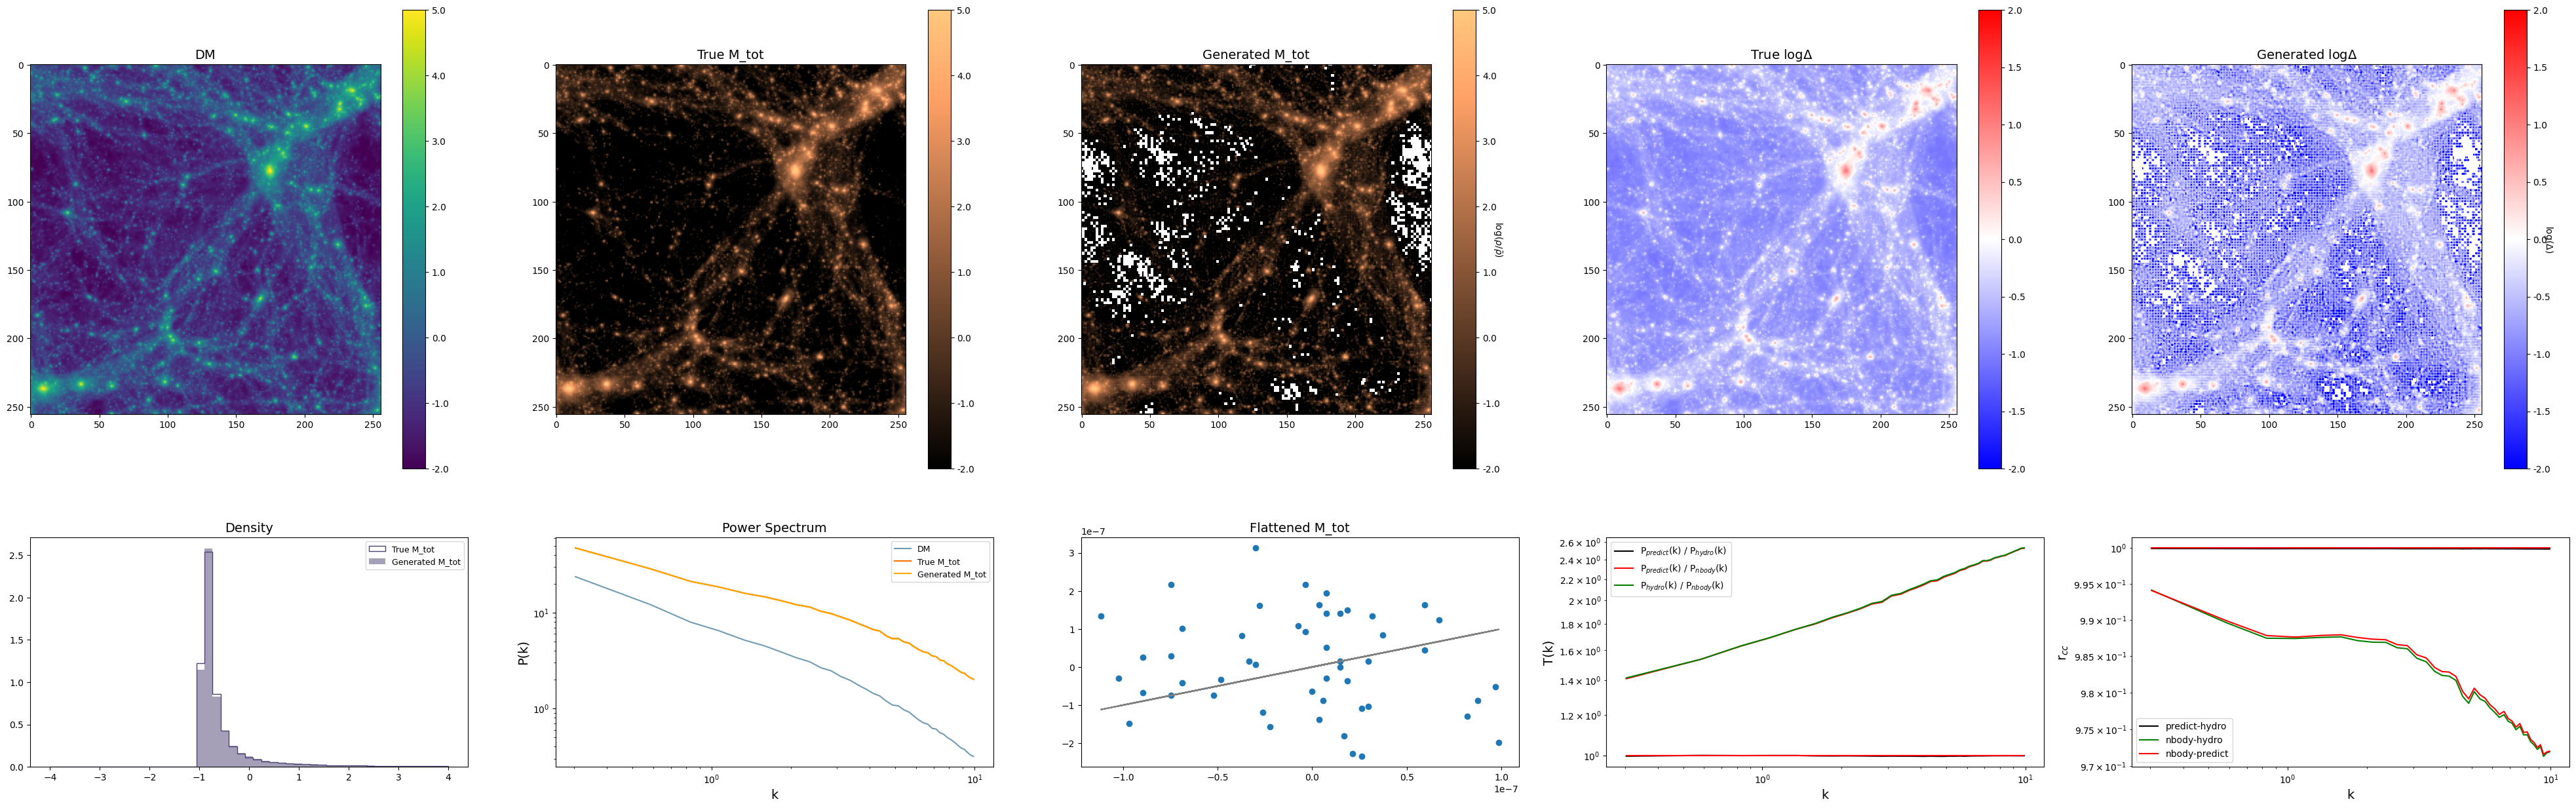

no high pass
Testing DataLoader 0: 100%|██████████| 6/6 [00:10<00:00,  0.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │   0.028056832030415535    │
│          l1_loss          │    0.09097705036401749    │
│         test_loss         │            0.0            │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody_power_1.3
COMET INFO:     url                   : https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss  : 0.028056832030415535
COMET INFO:     l1_loss       : 0.09097705036401749
COMET INFO:     test_loss [2] : (0.0, 0.01688675954937935)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : UNet_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbo

In [32]:
test_loss = trainer.test(model=None, datamodule=dm_toy, ckpt_path = path)

In [49]:
comet_logger.experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody_power_1.3
COMET INFO:     url                   : https://www.comet.com/klinjin/toy-model/0253f896d9c74a769c59597fb0abbf58
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : UNet_Film_epoch20_Movin

# $ M_{Nbody}+\lambda M_{Nbody}^{1.3}   : Rcc \sim M_{tot}$

In [35]:
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = False

state_dict=torch.load('/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0abbf58/checkpoints/latest-epoch=19-step=3500.ckpt'
, map_location=torch.device("cpu"))["state_dict"]

cnn.load_state_dict(state_dict)
cnn.eval()

error_nbody = []
error_CNN_FilMed_1 = []
rcc_nbody = []
rcc_CNN_FilMed_1 = []

simulations = np.arange(0, 300, 20)
for i in simulations:
    conditioning, params, target = dm_toy.test_data[i]
    residual_grid = cnn.cpu()(conditioning.cpu()[np.newaxis,:], params.cpu()[np.newaxis,:]).reshape(cropsize,cropsize) #path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere
    postTF_grid = conditioning.reshape(cropsize,cropsize) + residual_grid

    Pk2D_hydro = PKL.Pk_plane((conditioning+target).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane((conditioning).detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    Pk2D_postTF = PKL.Pk_plane((postTF_grid).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose) 
    Pk2D_res = PKL.Pk_plane(residual_grid.detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    Pk2D_res_true = PKL.Pk_plane(target.detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose) 
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    k_postTF   = Pk2D_postTF.k
    Pk_postTF   = Pk2D_postTF.Pk
    k_res   = Pk2D_res.k
    Pk_res   = Pk2D_res.Pk
    k_res_true   = Pk2D_res_true.k
    Pk_res_true   = Pk2D_res_true.Pk
    #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
    Pkcc = PKL.XPk_plane((conditioning+target).detach().numpy().reshape([256,256]),(postTF_grid).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc   = Pkcc.k
    Pk0_X = Pkcc.r
    Pkcc = PKL.XPk_plane((conditioning+target).detach().numpy().reshape([256,256]),(conditioning).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc_true   = Pkcc.k
    Pk0_X_true = Pkcc.r
    

    rcc_nbody.append(Pk0_X_true[kcc <= 10])
    rcc_CNN_FilMed_1.append(Pk0_X[kcc <= 10])
   
    
    error = 100*(Pk_Hydro-Pk_postTF)/Pk_Hydro
    error_CNN_FilMed_1.append(error[mask])
    error_true = 100*(Pk_Hydro-Pk_NBody)/Pk_Hydro
    error_nbody.append(error_true[mask])


/tmp/ipykernel_1208715/928938495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load('/pscratch/sd/l/lindajin/LOGS/toy_model/0253f896d9c74a769c59597fb0

no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power 

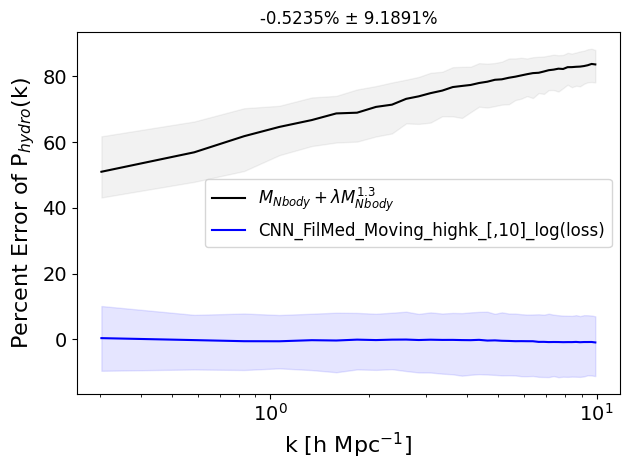

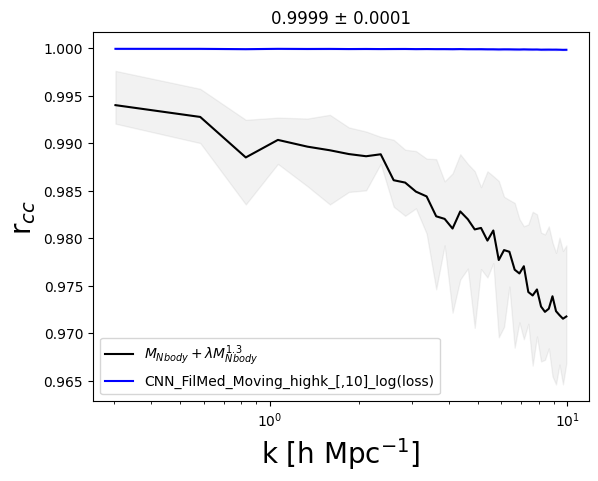

In [41]:
plt.figure()
median_spectrum = np.mean(error_nbody, axis=0)
min_spectrum = np.percentile(error_nbody, 5, axis=0)
max_spectrum = np.percentile(error_nbody, 95, axis=0)
plt.plot(k_NBody[mask], median_spectrum, color='k',label=r'$M_{Nbody}+\lambda M_{Nbody}^{1.3}$')
plt.fill_between(k_NBody[mask], min_spectrum, max_spectrum, color='k', alpha=0.05)
median_spectrum = np.mean(error_CNN_FilMed_1, axis=0)
min_spectrum = np.percentile(error_CNN_FilMed_1, 5, axis=0)
max_spectrum = np.percentile(error_CNN_FilMed_1, 95, axis=0)
plt.plot(k_NBody[mask], median_spectrum, color='b',label='CNN_FilMed_Moving_highk_[,10]_log(loss)')
plt.fill_between(k_NBody[mask], min_spectrum, max_spectrum, color='b', alpha=0.1)
mean_error = median_spectrum.mean()
sigma = ((max_spectrum - min_spectrum)/2).mean()
plt.title(f'{mean_error:.4f}% ± {sigma:.4f}%')
plt.xscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
plt.ylabel(r'Percent Error of P$_{hydro}$(k)', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

plt.figure()
median_spectrum = np.mean(rcc_nbody, axis=0)
min_spectrum = np.percentile(rcc_nbody, 16, axis=0)
max_spectrum = np.percentile(rcc_nbody, 84, axis=0)
plt.plot(kcc[kcc <= 10], median_spectrum, color='k',label=r'$M_{Nbody}+\lambda M_{Nbody}^{1.3}$')
plt.fill_between(kcc[kcc <= 10], min_spectrum, max_spectrum, color='k', alpha=0.05)
median_spectrum = np.mean(rcc_CNN_FilMed_1, axis=0)
min_spectrum = np.percentile(rcc_CNN_FilMed_1, 16, axis=0)
max_spectrum = np.percentile(rcc_CNN_FilMed_1, 84, axis=0)
mean_rcc = median_spectrum.mean()
sigma_rcc = ((max_spectrum - min_spectrum)/2).mean()
plt.title(f'{mean_rcc:.4f} ± {sigma_rcc:.4f}')
plt.plot(kcc[kcc <= 10], median_spectrum, color='b',label='CNN_FilMed_Moving_highk_[,10]_log(loss)')
plt.fill_between(kcc[kcc <= 10], min_spectrum, max_spectrum, color='b', alpha=0.1)
# Fill the area between the minimum and maximum power spectra
plt.xscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'r$_{cc}$', fontsize=20)
plt.legend()
plt.show()

# $ M_{Nbody}+\lambda M_{Nbody}^2$

In [44]:
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = False

state_dict=torch.load('/pscratch/sd/l/lindajin/LOGS/toy_model/3d221ce075da40bdbd48394131d6ad1f/checkpoints/latest-epoch=19-step=3500.ckpt'
, map_location=torch.device("cpu"))["state_dict"]
cnn.load_state_dict(state_dict)
cnn.eval()

error_nbody_2 = []
error_CNN_FilMed_2 = []
rcc_nbody_2 = []
rcc_CNN_FilMed_2 = []

simulations = np.arange(0, 300, 20)
for i in simulations:
    conditioning, params, target = dm_toy.test_data[i]
    residual_grid = cnn.cpu()(conditioning.cpu()[np.newaxis,:], params.cpu()[np.newaxis,:]).reshape(cropsize,cropsize) #path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere
    postTF_grid = conditioning.reshape(cropsize,cropsize) + residual_grid

    Pk2D_hydro = PKL.Pk_plane((conditioning+target).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane((conditioning).detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    Pk2D_postTF = PKL.Pk_plane((postTF_grid).detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose) 
    Pk2D_res = PKL.Pk_plane(residual_grid.detach().numpy().reshape([256,256]), BoxSize,  MAS, threads, verbose)
    Pk2D_res_true = PKL.Pk_plane(target.detach().numpy().reshape([256,256]), BoxSize, MAS, threads, verbose) 
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    k_postTF   = Pk2D_postTF.k
    Pk_postTF   = Pk2D_postTF.Pk
    k_res   = Pk2D_res.k
    Pk_res   = Pk2D_res.Pk
    k_res_true   = Pk2D_res_true.k
    Pk_res_true   = Pk2D_res_true.Pk
    #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
    Pkcc = PKL.XPk_plane((conditioning+target).detach().numpy().reshape([256,256]),(postTF_grid).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc   = Pkcc.k
    Pk0_X = Pkcc.r
    Pkcc = PKL.XPk_plane((conditioning+target).detach().numpy().reshape([256,256]),(conditioning).detach().numpy().reshape([256,256]),  BoxSize, MAS,MAS, threads=1) 
    kcc_true   = Pkcc.k
    Pk0_X_true = Pkcc.r
    

    rcc_nbody_2.append(Pk0_X_true[kcc <= 10])
    rcc_CNN_FilMed_2.append(Pk0_X[kcc <= 10])
   
    
    error = 100*(Pk_Hydro-Pk_postTF)/Pk_Hydro
    error_CNN_FilMed_2.append(error[mask])
    error_true = 100*(Pk_Hydro-Pk_NBody)/Pk_Hydro
    error_nbody_2.append(error_true[mask])


/tmp/ipykernel_1208715/2774642057.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load('/pscratch/sd/l/lindajin/LOGS/toy_model/3d221ce075da40bdbd4839413

no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds
no high pass

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power 

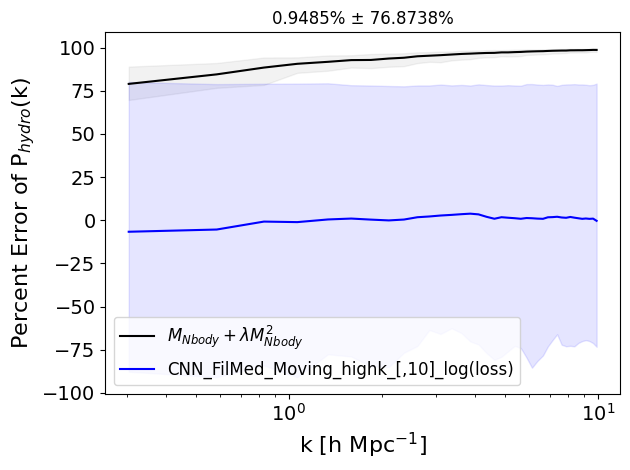

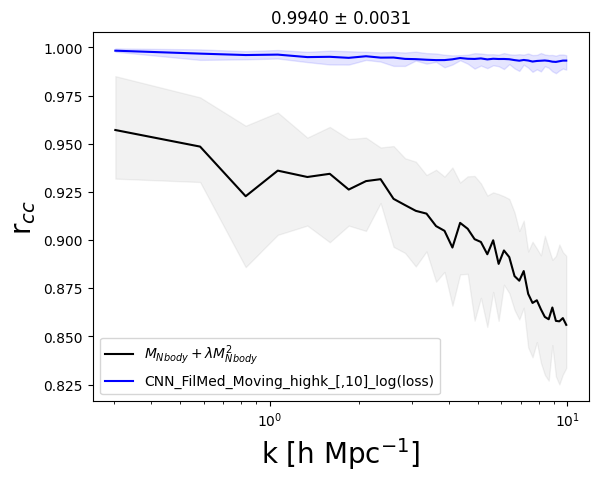

In [47]:
plt.figure()
median_spectrum = np.mean(error_nbody_2, axis=0)
min_spectrum = np.percentile(error_nbody_2, 5, axis=0)
max_spectrum = np.percentile(error_nbody_2, 95, axis=0)
plt.plot(k_NBody[mask], median_spectrum, color='k',label=r'$M_{Nbody}+\lambda M_{Nbody}^2$')
plt.fill_between(k_NBody[mask], min_spectrum, max_spectrum, color='k', alpha=0.05)
median_spectrum = np.mean(error_CNN_FilMed_2, axis=0)
min_spectrum = np.percentile(error_CNN_FilMed_2, 5, axis=0)
max_spectrum = np.percentile(error_CNN_FilMed_2, 95, axis=0)
plt.plot(k_NBody[mask], median_spectrum, color='b',label='CNN_FilMed_Moving_highk_[,10]_log(loss)' )
plt.fill_between(k_NBody[mask], min_spectrum, max_spectrum, color='b', alpha=0.1)
mean_error = median_spectrum.mean()
sigma = ((max_spectrum - min_spectrum)/2).mean()
plt.title(f'{mean_error:.4f}% ± {sigma:.4f}%')
plt.xscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
plt.ylabel(r'Percent Error of P$_{hydro}$(k)', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

plt.figure()
median_spectrum = np.mean(rcc_nbody_2, axis=0)
min_spectrum = np.percentile(rcc_nbody_2, 16, axis=0)
max_spectrum = np.percentile(rcc_nbody_2, 84, axis=0)
plt.plot(kcc[kcc <= 10], median_spectrum, color='k',label=r'$M_{Nbody}+\lambda M_{Nbody}^2$')
plt.fill_between(kcc[kcc <= 10], min_spectrum, max_spectrum, color='k', alpha=0.05)
median_spectrum = np.mean(rcc_CNN_FilMed_2, axis=0)
min_spectrum = np.percentile(rcc_CNN_FilMed_2, 16, axis=0)
max_spectrum = np.percentile(rcc_CNN_FilMed_2, 84, axis=0)
mean_rcc = median_spectrum.mean()
sigma_rcc = ((max_spectrum - min_spectrum)/2).mean()
plt.title(f'{mean_rcc:.4f} ± {sigma_rcc:.4f}')
plt.plot(kcc[kcc <= 10], median_spectrum, color='b',label='CNN_FilMed_Moving_highk_[,10]_log(loss)')
plt.fill_between(kcc[kcc <= 10], min_spectrum, max_spectrum, color='b', alpha=0.1)
# Fill the area between the minimum and maximum power spectra
plt.xscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'r$_{cc}$', fontsize=20)
plt.legend()
plt.show()